# Zernike Wavefront sensor

Zernike polynomials can be used to describe the aberrations in optical wavefront traveling through a circular aperture. They are often used to explain the shape of an aberrated wavefront in the pupil of an optical system.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import math

We will start by creating a 2D co-ordinate array and then apply a circular mask to act as the pupil for our system. The pupil will initally have an electric field of uniform amplitude passing through it.

In [2]:
pixels = 512        #size of arrays
wavelength = 0.68

x = np.arange( -pixels / 2, pixels / 2)
y = x

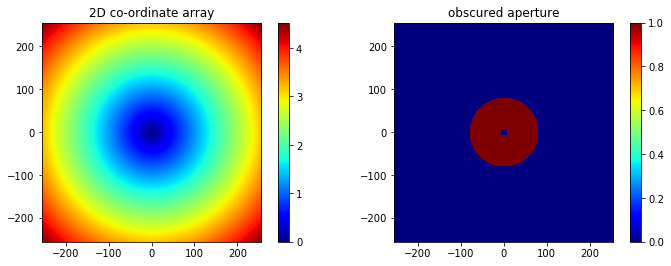

In [45]:
pupilRadius = 80
pupilRadius2 = 80*0.1

#meshgrid function used to create a co-ordinate
#array that vectorises x and y
X, Y = np.meshgrid(x, y)

theta = np.arctan2(Y,X)

#R is now an array with values equal to the distance
# from the center of the N x N array:
R = np.sqrt((X)**2 + (Y)**2)


#create a circular disk with a hole in the centre
msk = (R <= pupilRadius)
msk2 = (R <= pupilRadius2)

d = np.zeros((pixels, pixels))
d[msk]=1

d2 = np.zeros((pixels, pixels))
d2[msk2]=1

aperture = d - d2

#normalise co-ordinate array to pupil radius
R_norm = R/pupilRadius


#pupilMask = pupilMask * image

fig = plt.figure(figsize=(10, 7))

plt.subplot(221)
plt.imshow(R_norm, extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
#plt.xlabel('microns')
#plt.ylabel('microns')
plt.title('2D co-ordinate array')
plt.colorbar()

plt.subplot(222)
plt.imshow(aperture, extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
plt.title('obscured aperture')
plt.colorbar()


plt.tight_layout()
plt.show()

#adjust co-ordinates so that the pupil is between 0 and 1

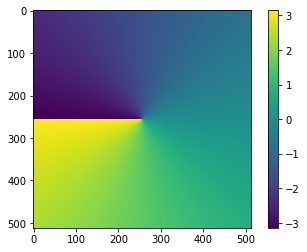

3.14159265359


In [46]:
fig = plt.figure()
plt.imshow(theta)
plt.colorbar()
plt.show()

print(np.max(theta))

Now that we have generated our input pupil for the incoming wavefront, we can find the point spread function of the system by taking a Fourier transform of the circular pupil.

In [47]:
#define a function that can calculate all the variables we need, psf, phase and angle

def PSF(array):
    
    global fft, psf, phase
    
    #fourier transform of curcular pupil
    #fftshift function moves zero frequency function to the centre of the array
    fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(array)))
    
    #change the fft into an intensity distribution
    psf = np.abs(fft)**2
    #normalise the psf
    #psf = psf/np.max((psf))
    
    #extract angle information from the pupil
    phase = np.angle(fft)
    
    return {'fft':fft ,'psf':psf, 'phase':phase}


def OTF(array):
    
    global ifft, I, Iphase
    
    ifft = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(array)))
    
    I = np.abs(ifft)**2
    #I = I/np.max((I))
    
    Iphase = np.angle((ifft))
    
    return {'ifft':ifft, 'I':I, 'Iphase':Iphase }

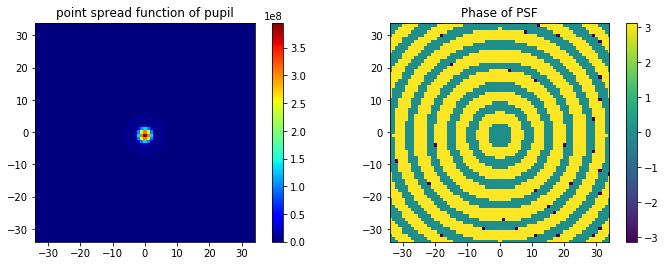

In [48]:
PSF(aperture)

fig = plt.figure(figsize=(10,7))
plt.clf()
plt.subplot(221)
plt.imshow((psf), extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
plt.gca().set_xlim((-34, 34))
plt.gca().set_ylim((-34, 34))
plt.title('point spread function of pupil')
plt.colorbar()

plt.subplot(222)
plt.imshow((phase), extent=(x.min(), x.max(), x.min(), x.max()))
plt.gca().set_xlim((-34, 34))
plt.gca().set_ylim((-34, 34))
plt.title('Phase of PSF')
plt.colorbar()

plt.tight_layout()
plt.show()

## Wavefront Aberrations

So far we have created a basic optical system with no wavefront aberrations. We can model wavefront aberrations by multiplying the pupil array of the aperture by a zernike polynomial.

In [49]:

#Aberrated wavefronts
#Zernike Polynomials * pupil

Z_0 = 1
Z_1 = 2*R_norm*np.sin(theta)                                     #Y-Tilt
Z_2 = 2*R_norm*np.cos(theta)                                     #X-Tilt
Z_3 = np.sqrt(6)*(R_norm**2)*np.sin(2*theta)                     #Oblique astigmatism
Z_4 = np.sqrt(3)*(2*(R_norm**2)-1)                               #Defocus
Z_5 = np.sqrt(6)*(R_norm**2)*np.cos(2*theta)                     #Vertical astigmatism
Z_6 = np.sqrt(8)*(R_norm**3)*np.sin(3*theta)                     #Vertical Trefoil
Z_7 = np.sqrt(8)*(3*(R_norm**3)-2*R_norm)*np.sin(theta)          #Vertical Coma
Z_8 = np.sqrt(8)*(3*(R_norm**3)-2*R_norm)*np.cos(theta)          #Horizontal Coma
Z_9 = np.sqrt(8)*(R_norm**3)*np.sin(3*theta)                     #Oblique trefoil
Z_10 = np.sqrt(10)*(R_norm**4)*np.sin(4*theta)                   #Oblique quadrafoil
Z_11 = np.sqrt(10)*(4*(R_norm**4)-3*(R_norm**2))*np.sin(2*theta) #Oblique seconday astigmatism
Z_12 = np.sqrt(5)*(6*(R_norm**4)-6*(R_norm**2)+1)                #primary spherical
Z_13 = np.sqrt(10)*(4*(R_norm**4)-3*(R_norm**2))*np.cos(2*theta) #Vertical secondary astigmatism  
Z_14 = np.sqrt(10)*(R_norm**4)*np.cos(4*theta)                   #Vertical quadrafoil

#-------------------------------------------------------------------------

Zernike_polynomials = np.array([Z_1, Z_2, Z_3, Z_4, Z_5, Z_6, Z_7, Z_8, Z_9, Z_10, Z_11, Z_12, Z_13, Z_14])

#need to map aberrations to normalised co-ordinates
for i in range(len(Zernike_polynomials)):
    Zernike_polynomials[i][R_norm>1]=0




titles = ['pupil', 'Y-Tilt', 'X-Tilt','Oblique astigmatism', 'Defocus', 'Vertical astigmatism', 'Vertical Trefoil', 
          'Vertical Coma', 'Horizontal Coma', 'Oblique trefoil', 'Oblique quadrafoil', 'Oblique seconday astigmatism',
          'primary spherical', 'Vertical secondary astigmatism', 'Vertical quadrafoil']

RMS = []

for i in range(len(Zernike_polynomials)):
    
    root_mean_square = np.sqrt(np.sum(Zernike_polynomials[i]**2))
    RMS.append(root_mean_square)

print(RMS)

[141.61897824797353, 141.61897824797353, 141.83422180489444, 141.53227841313264, 141.22695012428133, 141.44324951375725, 141.44692349375748, 141.44692349375748, 141.44324951375725, 141.28297049125871, 141.86527092323362, 141.36528588150605, 140.85881504329021, 141.42898352414051]


In [50]:
wavelength = 0.68 #microns
rms = 1/30
delta = Zernike_polynomials/wavelength
#Convert to phase
pupil = aperture * np.exp((rms*delta)*2*np.pi*1j)
print(np.shape(pupil))


#map pupil functions to aperture radius
for i in range(len(pupil)):
    pupil[i][R_norm>1]=0


(14, 512, 512)


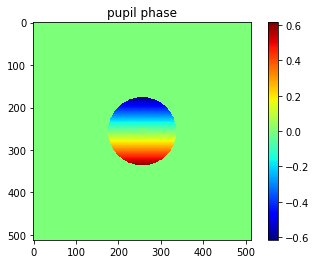

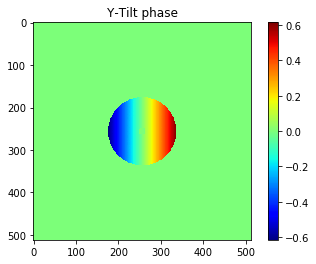

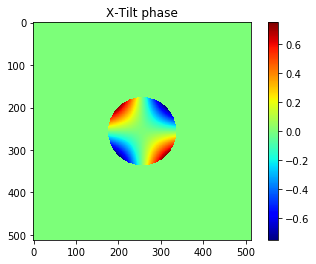

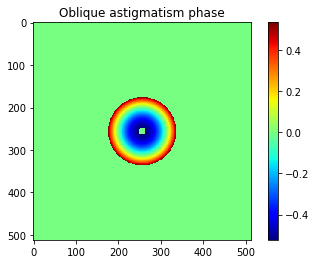

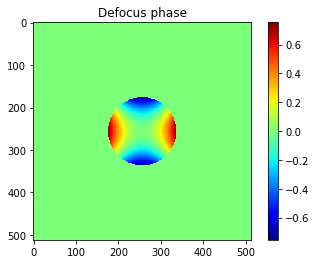

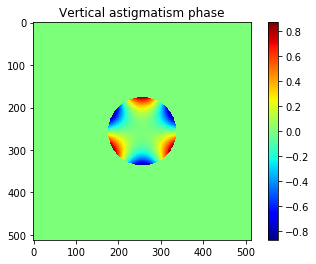

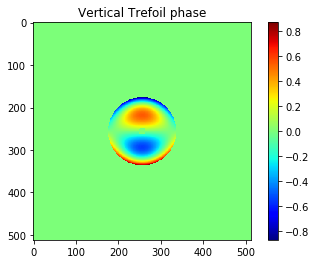

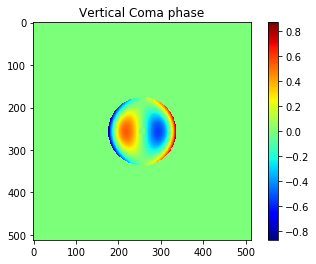

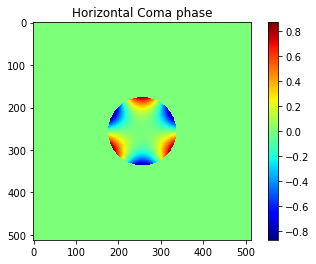

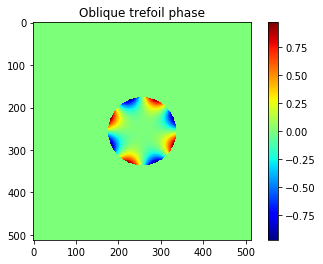

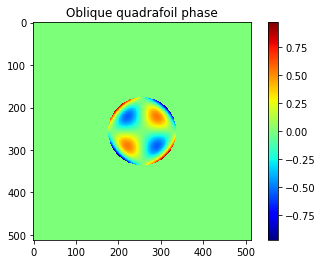

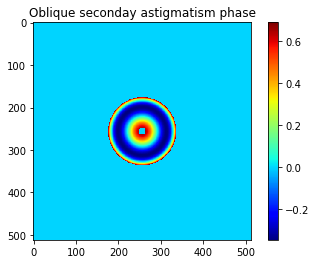

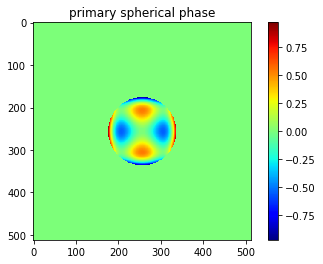

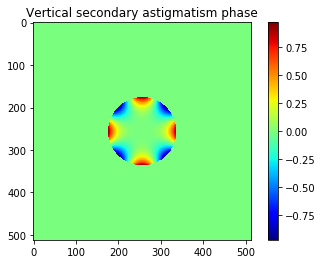

In [51]:
t = 0
for i in range(len(pupil)):
    
    fig = plt.figure()
    
    plt.imshow(np.angle(pupil[i]), Cmap='jet')
    
    plt.title(titles[t]+' phase')
    #plt.gca().set_xlim((-34, 34))
    #plt.gca().set_ylim((-34, 34))
    plt.colorbar()
    t+=1
    #show the intensity distribution and show that inside the pupil is one and zero elsewhere
plt.show()

We now want to see how these Zernike polynomials effect to PSF, which can be dont by taking their fourier transform.

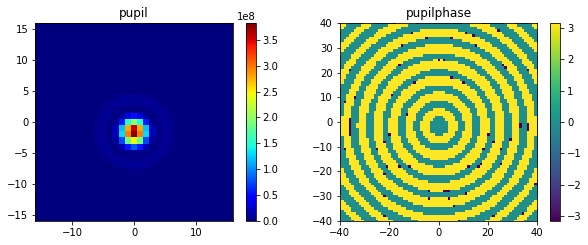

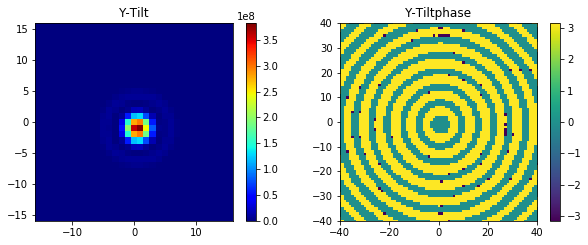

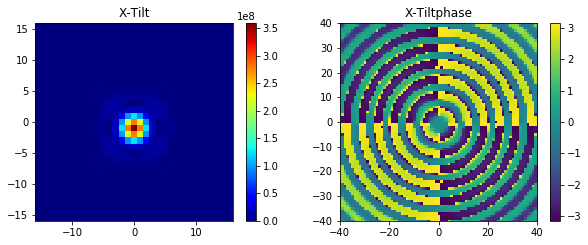

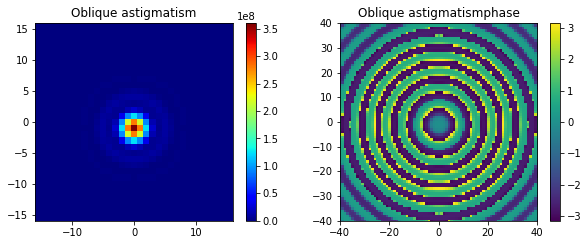

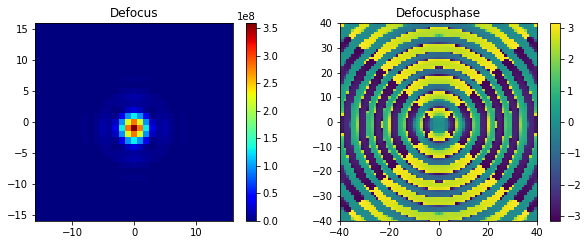

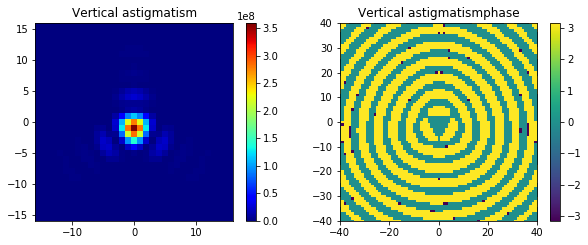

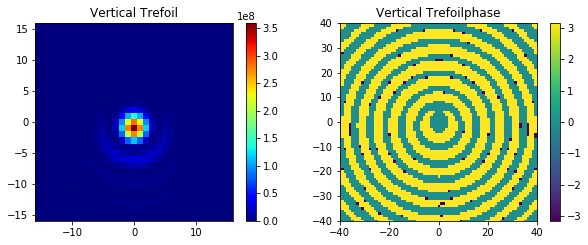

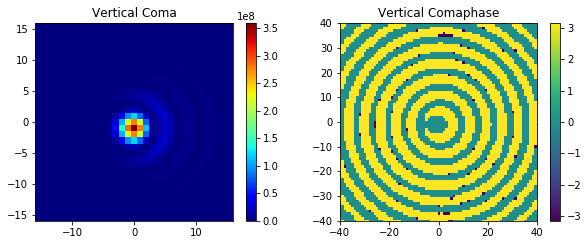

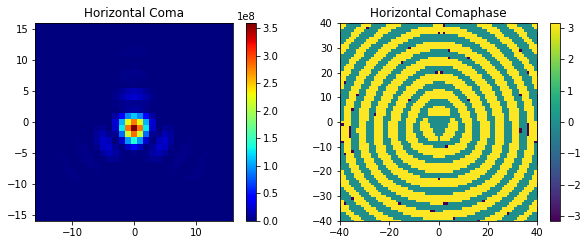

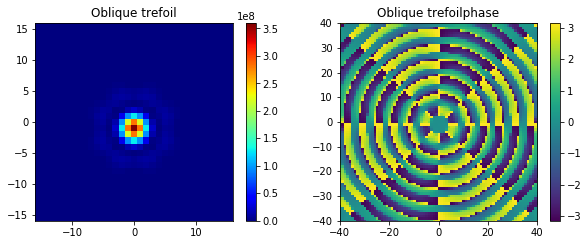

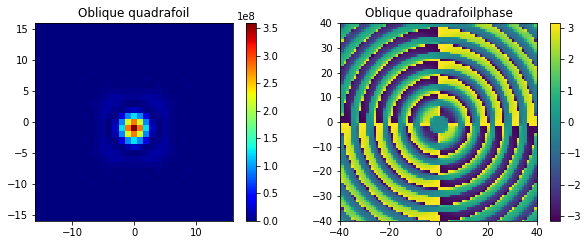

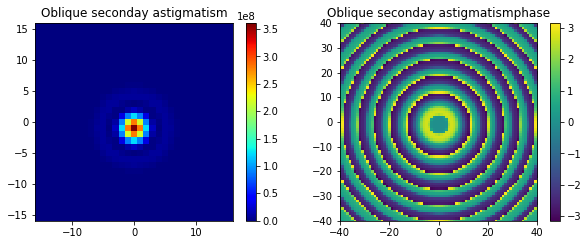

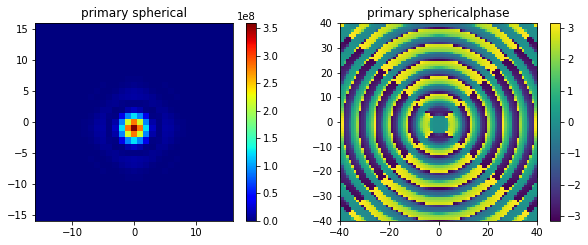

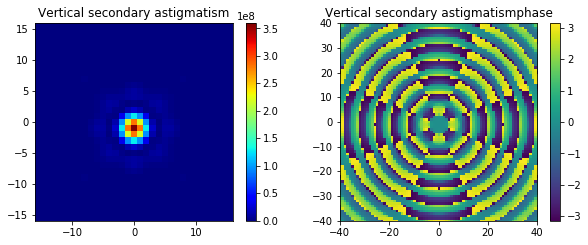

In [52]:

fourier_plane = []
t=0
for i in range(len(pupil)):
    
    fourier_plane.append((PSF(pupil[i])))
    
    fig = plt.figure(figsize=(10,8))
    plt.clf()
    plt.subplot(221)
    plt.imshow((fourier_plane[i]['psf']), extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
    plt.gca().set_xlim((-16, 16))
    plt.gca().set_ylim((-16, 16))
    plt.title(titles[t])
    plt.colorbar()

    plt.subplot(222)
    plt.imshow((fourier_plane[i]['phase']), extent=(x.min(), x.max(), x.min(), x.max()))
    plt.gca().set_xlim((-40, 40))
    plt.gca().set_ylim((-40, 40))
    plt.title(titles[t]+'phase')
    plt.colorbar()
    plt.show()
    #print(i)
    #fig.savefig(titles[t] + "_Intensity" + ".pdf")
    t+=1
    
    
plt.show() 

#  Phase Shift filter

We can simulate the efeect of a phase contrast filter by intriducing a phase shift to the system.
This can be acheved by creating another aperture with a phase shift of pi/2 and multiplying it by our object in the Fourier plane.
The phase shift will create another pertubrbed synthetic reference wavefront that has the ability to interfere with the original wavefront. The interference will give rise to an intensity distribution that allows us to examine the phase aberration of the system.

PCF radius:  2.0


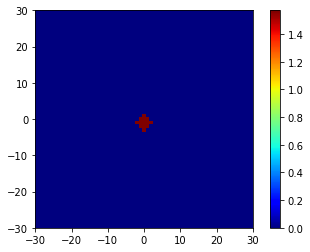

In [53]:
#PCF need to be a size comparable to that of the airy disk

PCF_radius = 2.0
print("PCF radius: ",  PCF_radius)
R_norm2 = R/PCF_radius
mask2 = np.ones((pixels, pixels))


#introduce multiple phase shifts
PCF_1 = mask2 * np.exp(-1j*(np.pi/2))
PCF_1[R_norm2>1]=1

PCF_2 = mask2 *np.exp(1j*0)
PCF_2[R_norm2>1]=1

PCF_3 = mask2 * np.exp(1j*(np.pi/2))
PCF_3[R_norm2>1]=1

PCF_4 = mask2 * np.exp(1j*np.pi)
PCF_4[R_norm2>1]=1

#Intensity of filter is 1 throughout
#phase shift is applied only to area of PCF

fig = plt.figure()
plt.imshow(np.angle(PCF_3), extent = (x.min(), x.max(), y.min(), y.max()), Cmap='jet')
plt.gca().set_xlim((-30,30))
plt.gca().set_ylim((-30,30))
plt.colorbar()
plt.show()

#np.savetxt('PCF', np.abs(PCF))



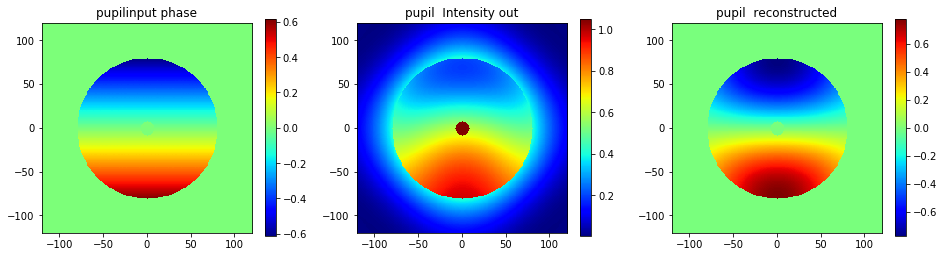

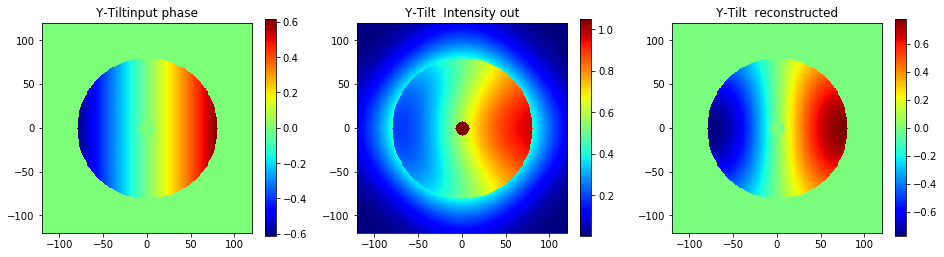

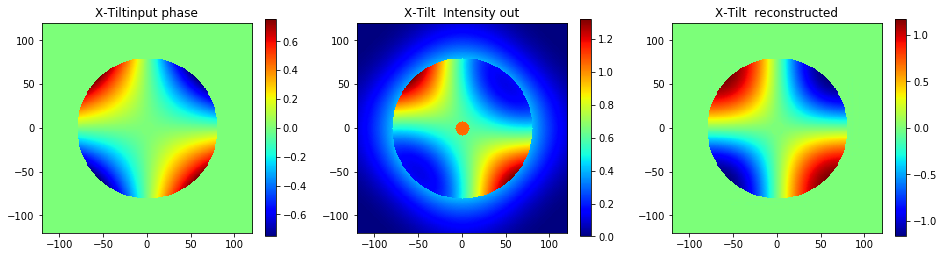

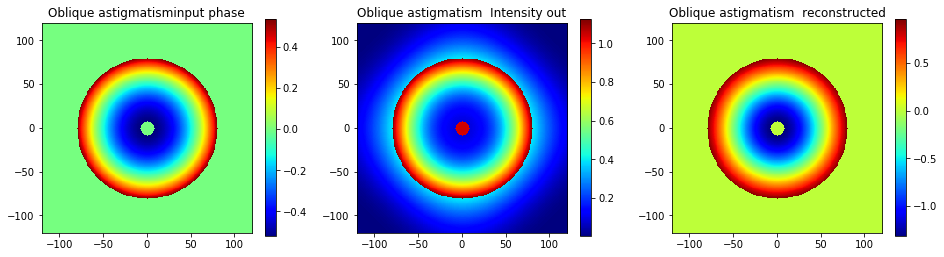

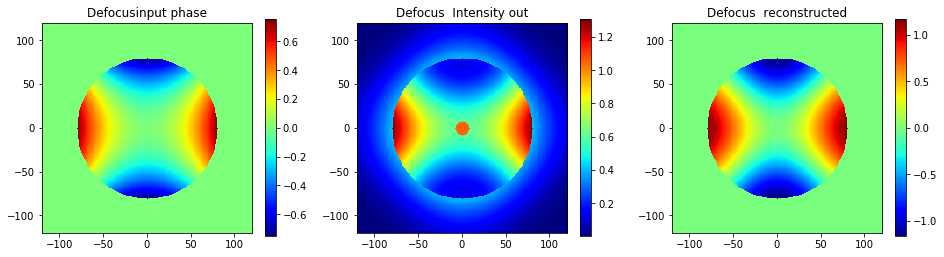

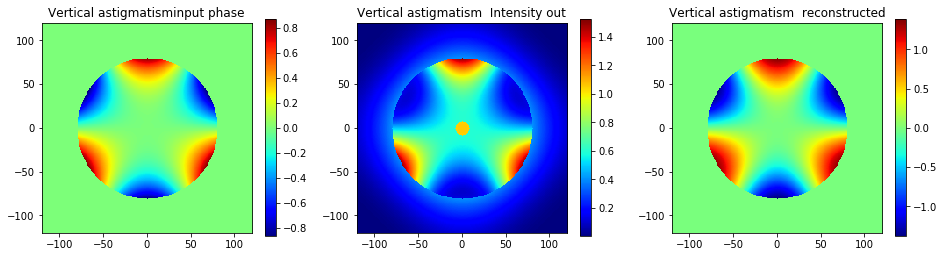

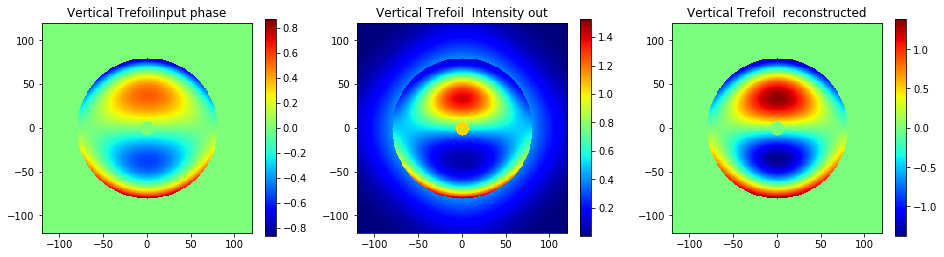

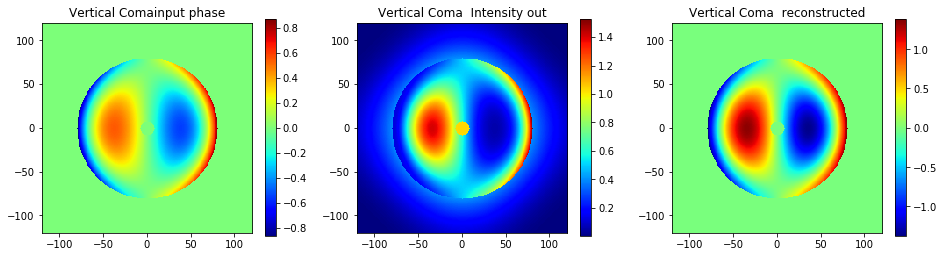

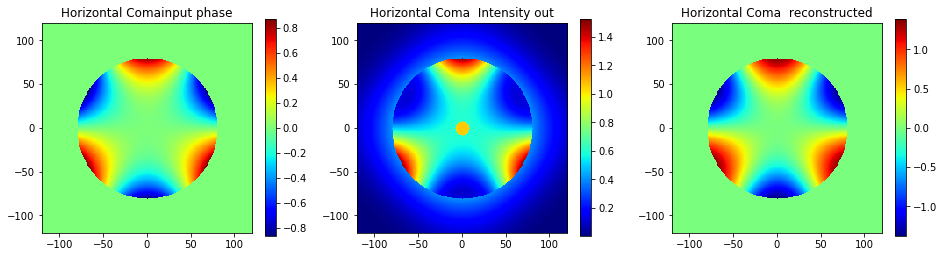

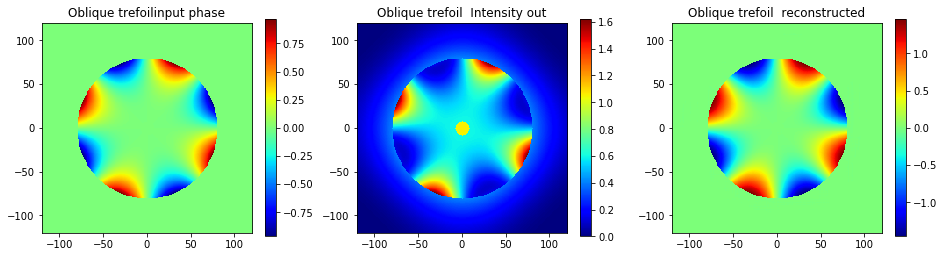

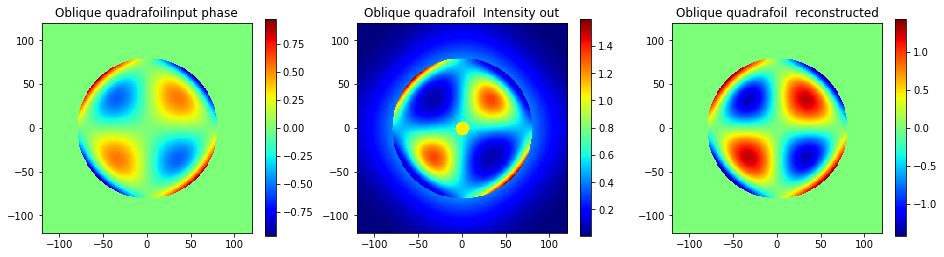

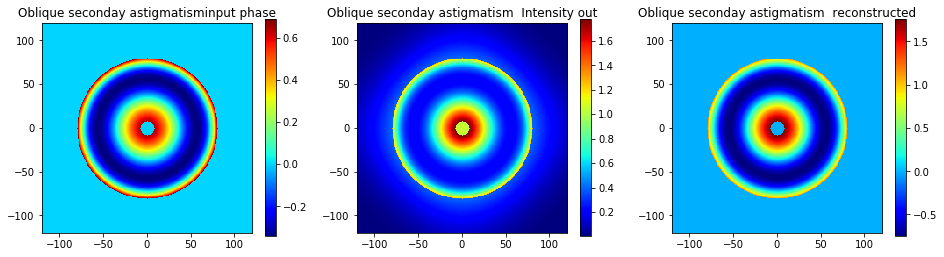

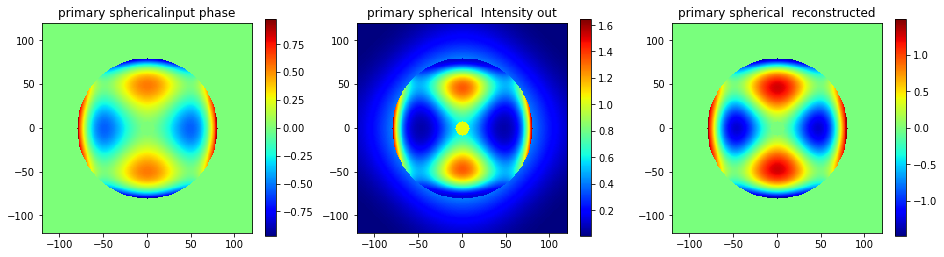

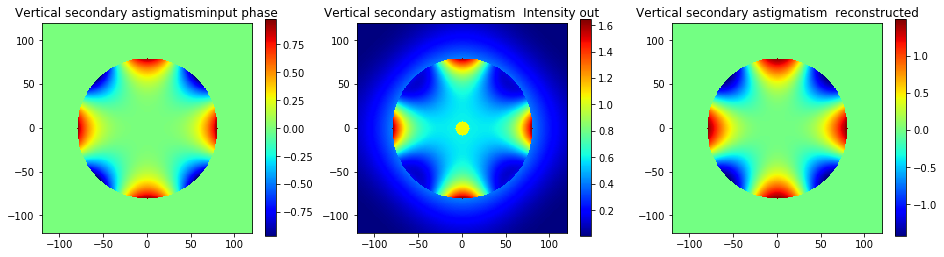

In [54]:
#Phase reconstruction from 
#https://www.spiedigitallibrary.org/conference-proceedings-of-spie/8126/81260F/Phase-shifting-Zernike-interferometer-wavefront-sensor/10.1117/12.892843.full?SSO=1



t=0
reconstructed_phase=[]
ratios=[]
E_1 = []
#E_2 = []
E_3 = []
#E_4 = []
fourier_plane2 = []
for i in range(len(pupil)):
    
    #synthetic reference wavefront
    SRW_1 = fourier_plane[i]['fft'] * PCF_1
    #SRW_2 = fourier_plane[i]['fft'] * PCF_2
    SRW_3 = fourier_plane[i]['fft'] * PCF_3
    #SRW_4 = fourier_plane[i]['fft'] * PCF_4
    
    E_1.append(OTF(SRW_1))
    #E_2.append(OTF(SRW_2))
    E_3.append(OTF(SRW_3))
    #E_4.append(OTF(SRW_4))
    
    reconstructed_phase.append(((E_3[i]['I'] - E_1[i]['I'])))
    
    fig = plt.figure(figsize=(16,4))
    plt.clf()
    plt.subplot(131)
    plt.imshow(np.angle(pupil[i]), extent=(x.min(), x.max(), x.min(), x.max()), Cmap='jet')
    plt.gca().set_xlim((-120, 120))
    plt.gca().set_ylim((-120, 120))
    plt.colorbar()
    plt.title(titles[t] + 'input phase')
    
    plt.subplot(132)
    plt.imshow((E_3[i]['I']),  extent=(x.min(), x.max(), x.min(), x.max()) , Cmap='jet')
    plt.gca().set_xlim((-120, 120))
    plt.gca().set_ylim((-120, 120))
    plt.title(titles[t]+ '  Intensity out')
    plt.colorbar()
    
    plt.subplot(133)
    plt.imshow((reconstructed_phase[i]),  extent=(x.min(), x.max(), x.min(), x.max()) , Cmap='jet')
    plt.gca().set_xlim((-120, 120))
    plt.gca().set_ylim((-120, 120))
    plt.title(titles[t]+ '  reconstructed')
    plt.colorbar()
    
    t+=1
    
    
plt.show()